In [16]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
import torch.nn as nn
from torch.distributions import Normal
from torch.distributions.kl import kl_divergence
import sys
sys.path.append('..')

import logging
from src.utils import setup_logging
setup_logging(console=True, file=False, debug=True)
logger = logging.getLogger(__name__)

from src.plot import plot_predictive
from src.informed_np import InformedNeuralProcess
from tqdm import tqdm
# from src.loss import ELBOLoss
from src.loss import ELBOLoss
from src.train import train    

[INFO]: Logging setup completed at 14-08-2024-153743        (utils.py:62 [15:37:43])
[INFO]: Logging setup completed at 14-08-2024-153743        (utils.py:62 [15:37:43])


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


['The night will start off chilly with temperatures around 8 degrees, dropping to a cool 5.5 degrees in the early morning, before warming up to a pleasant 21 degrees in the late afternoon. Temperatures will then gradually cool down to around 13 degrees by midnight.']


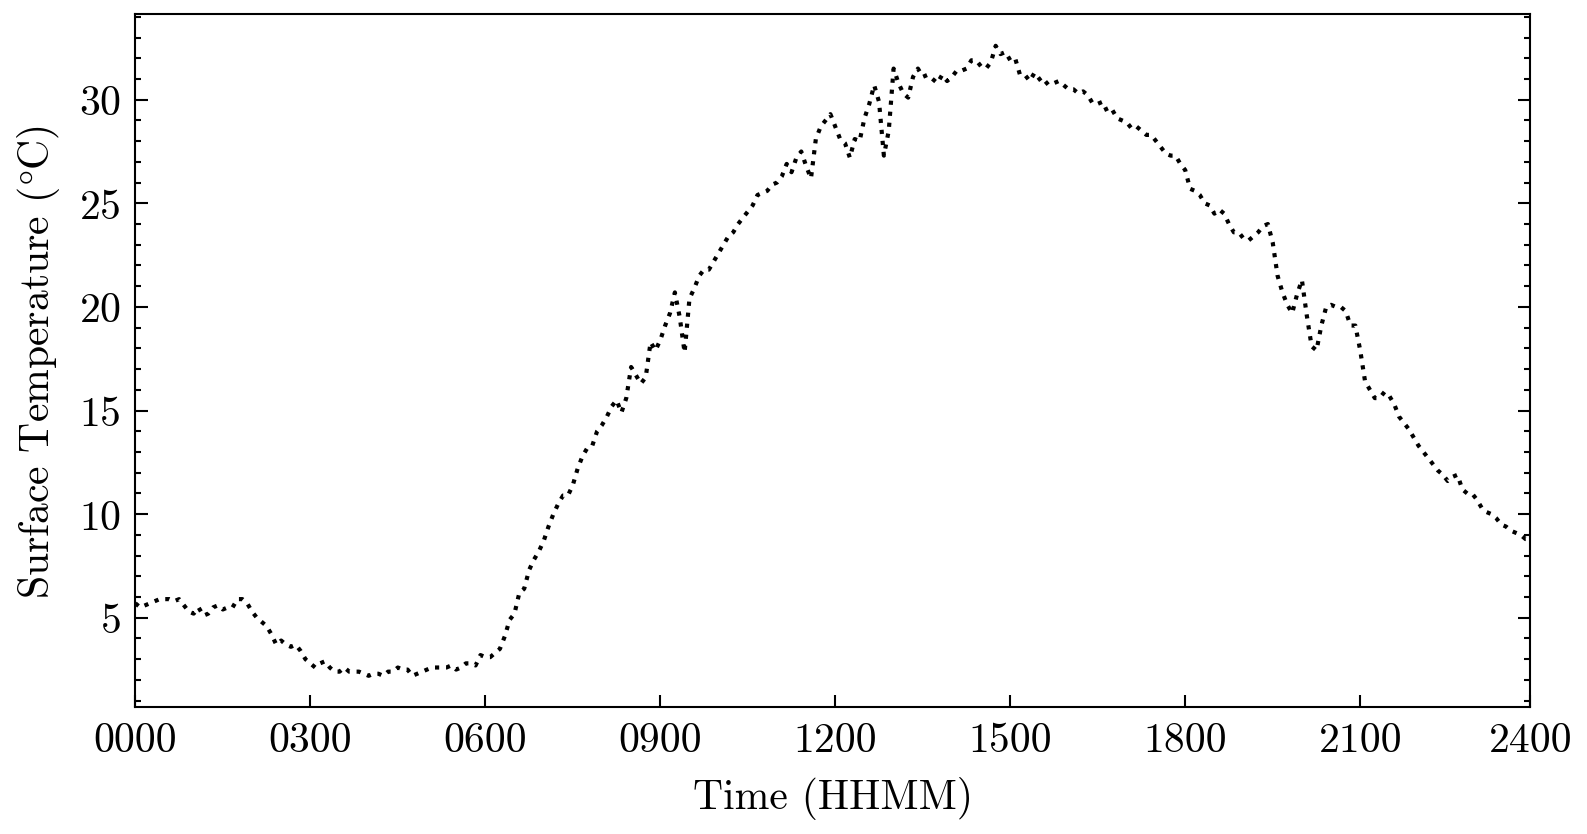

In [17]:
import pandas as pd
from data.tempdata import TempData
import matplotlib.pyplot as plt
# Load the data
data_path = '../data/surface_temp_with_desc_cleaned1.csv'
data = pd.read_csv(data_path, header=None)
data_test = TempData(data=data, max_num_context=10, device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))

temporary_batch_size = 1
batch = data_test.generate_batch(batch_size=temporary_batch_size, split='val', return_knowledge=True)
plt.style.use('../figures/mplstyles/thesis.mplstyle')
fig = plt.figure(figsize=(6,3))
print(batch.knowledge)
for i in range(temporary_batch_size):
    x_target = batch.x_target[i].flatten()
    y_target = batch.y_target[i].flatten()
    plt.plot(x_target.numpy(), y_target.numpy(), 'k:')
# for i in range(temporary_batch_size):
#     x_context = batch.x_context[i].flatten()
#     y_context = batch.y_context[i].flatten()
#     plt.scatter(x_context.numpy(), y_context.numpy())
plt.xlim(-2, 2)
    # Formatting the x-axis to display time in "HHMM" format
plt.xticks(list(x_target[::36])+ [2.0], labels=["0000", "0300", "0600", "0900", "1200", "1500", "1800", "2100", "2400"])

# Label axes
plt.xlabel('Time (HHMM)')
plt.ylabel(r'Surface Temperature ($\degree$C)')

fig.savefig('../figures/surf_temperature_sample2', dpi=300)
plt.show()

In [18]:
def eval(model, data, use_knowledge=True, num_context=None):
    model.training = False
    with torch.no_grad():
        test_loss = 0
        n_test_batches = 128
        test_batch_size = 96
        for _ in range(n_test_batches):
            batch = data.generate_batch(batch_size=test_batch_size,
                                    device=DEVICE,
                                    return_knowledge=use_knowledge,
                                    split='test',
                                    num_context=num_context)

            p_y_pred, q_z_context, q_z_target = model(batch.x_context,
                                                  batch.y_context,
                                                  batch.x_target,
                                                  batch.y_target,
                                                  batch.knowledge)
            test_loss_dict = loss_function(p_y_pred, q_z_context, None, batch.y_target)
            test_loss += test_loss_dict["loss"].item() / n_test_batches
        # val_losses.append(val_loss)
        
    model.training = True
    print(f"Test Loss: {test_loss}, use_knowledge={use_knowledge}, num_context={num_context}")
    return test_loss

def k_and_nok_eval(model, data):
    k_test_losses = []
    nok_test_losses = []

    for num_context in range(1, 11):
        k_test_losses.append(eval(model, data, use_knowledge=True, num_context=num_context))
        nok_test_losses.append(eval(model, data, use_knowledge=False, num_context=num_context))

    return k_test_losses, nok_test_losses

In [19]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
logging.info(f'Using DEVICE: {DEVICE}')

x_dim = 1
y_dim = 1
determ_dim = 128  # Dimension of representation of context points
latent_dim = 128  # Dimension of sampled latent variable
hidden_dim = 128  # Dimension of hidden layers in encoder and decoder

args = dict(
            x_dim=x_dim,
            y_dim=y_dim,
            hidden_dim=hidden_dim,
            latent_dim=latent_dim,
            determ_dim=determ_dim,
            knowledge_dim=128,
            mlps_activation=nn.GELU(),
            x_proj_dim=1,
            n_h_layers_x_proj=0,
            n_h_layers_decoder=4,
            n_h_layers_latent_xy_encoder=3,
            n_h_layers_film_latent_encoder=3,
            path='latent',
            train_num_z_samples=4,
            test_num_z_samples=32,
            use_bias=True,
            use_context_in_target=True, # TODO investigate
            use_latent_self_attn=True,
            # use_determ_self_attn=True,
            # use_determ_cross_attn=True,
            # use_knowledge=USE_KNOWLEDGE,
            # knowledge_dropout=0.3,
            roberta_return_cls=True,
            tune_llm_layer_norms=True,
            freeze_llm=True,
            knowledge_projection_n_h_layers=0,
            knowledge_aggregation_method='FiLM+MLP',
            device='cuda',
            beta=1.0
        )
assert "use_knowledge" not in args
assert "knowledge_dropout" not in args

data_path = '../data/surface_temp_with_desc_cleaned1.csv'
data_df = pd.read_csv(data_path, header=None)

AVG_LOSS_PRINT_INTERVAL = 250
PLOT_SAMPLE_INTERVAL = 1000
MAX_ITERS = 10000

LEARNING_RATE = 1e-3
loss_function = ELBOLoss(beta=1, reduction='mean')
random_states = [66, 3, 44]

MAX_NUM_CONTEXT = 10

# RANDOM_STATE = 42 # 'pseudo' random :)

[INFO]: Using DEVICE: cuda:0        (1586923886.py:2 [15:37:49])
[INFO]: Using DEVICE: cuda:0        (1586923886.py:2 [15:37:49])


# NP

[INFO]: USE_KNOWLEDGE: False        (2661624839.py:3 [15:37:51])
[INFO]: USE_KNOWLEDGE: False        (2661624839.py:3 [15:37:51])
[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [15:37:51])
[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [15:37:51])
[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [15:37:52])
[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [15:37:52])
[DEBUG]: XYEncoder has x_dim=1 and y_dim=1        (xy_encoders.py:57 [15:37:52])
[DEBUG]: XYEncoder has x_dim=1 and y_dim=1        (xy_encoders.py:57 [15:37:52])
[INFO]: Saving new best val loss model at iter 1        (train.py:122 [15:37:53])
[INFO]: Saving new best val loss model at iter 1        (train.py:122 [15:37:53])


iter 1: Val. Loss (NLL): 50819.58819580078


[INFO]: Removing model at path '../exp/surf_temp/np-rs-66_iter1.pt'        (train.py:129 [15:37:58])
[INFO]: Removing model at path '../exp/surf_temp/np-rs-66_iter1.pt'        (train.py:129 [15:37:58])
[INFO]: Saving new best val loss model at iter 250 to path ../exp/surf_temp/np-rs-66_iter250.pt        (train.py:134 [15:37:58])
[INFO]: Saving new best val loss model at iter 250 to path ../exp/surf_temp/np-rs-66_iter250.pt        (train.py:134 [15:37:58])


iter 250: Val. Loss (NLL): 1065.4237332344055


[INFO]: Removing model at path '../exp/surf_temp/np-rs-66_iter250.pt'        (train.py:129 [15:38:04])
[INFO]: Removing model at path '../exp/surf_temp/np-rs-66_iter250.pt'        (train.py:129 [15:38:04])
[INFO]: Saving new best val loss model at iter 500 to path ../exp/surf_temp/np-rs-66_iter500.pt        (train.py:134 [15:38:04])
[INFO]: Saving new best val loss model at iter 500 to path ../exp/surf_temp/np-rs-66_iter500.pt        (train.py:134 [15:38:04])


iter 500: Val. Loss (NLL): 866.9164538383484
iter 750: Val. Loss (NLL): 1167.4894170761108
iter 1000: Val. Loss (NLL): 1029.0152425765991
iter 1250: Val. Loss (NLL): 1051.1589708328247
iter 1500: Val. Loss (NLL): 1895.274006843567
iter 1750: Val. Loss (NLL): 1495.0978574752808
iter 2000: Val. Loss (NLL): 1264.9084582328796
iter 2250: Val. Loss (NLL): 963.464243888855
iter 2500: Val. Loss (NLL): 1159.7734456062317
iter 2750: Val. Loss (NLL): 1174.858111858368


[INFO]: time_since_prev_best_val >=5. EXITING TRAINING        (train.py:148 [15:39:22])
[INFO]: time_since_prev_best_val >=5. EXITING TRAINING        (train.py:148 [15:39:22])


iter 3000: Val. Loss (NLL): 1088.6498341560364


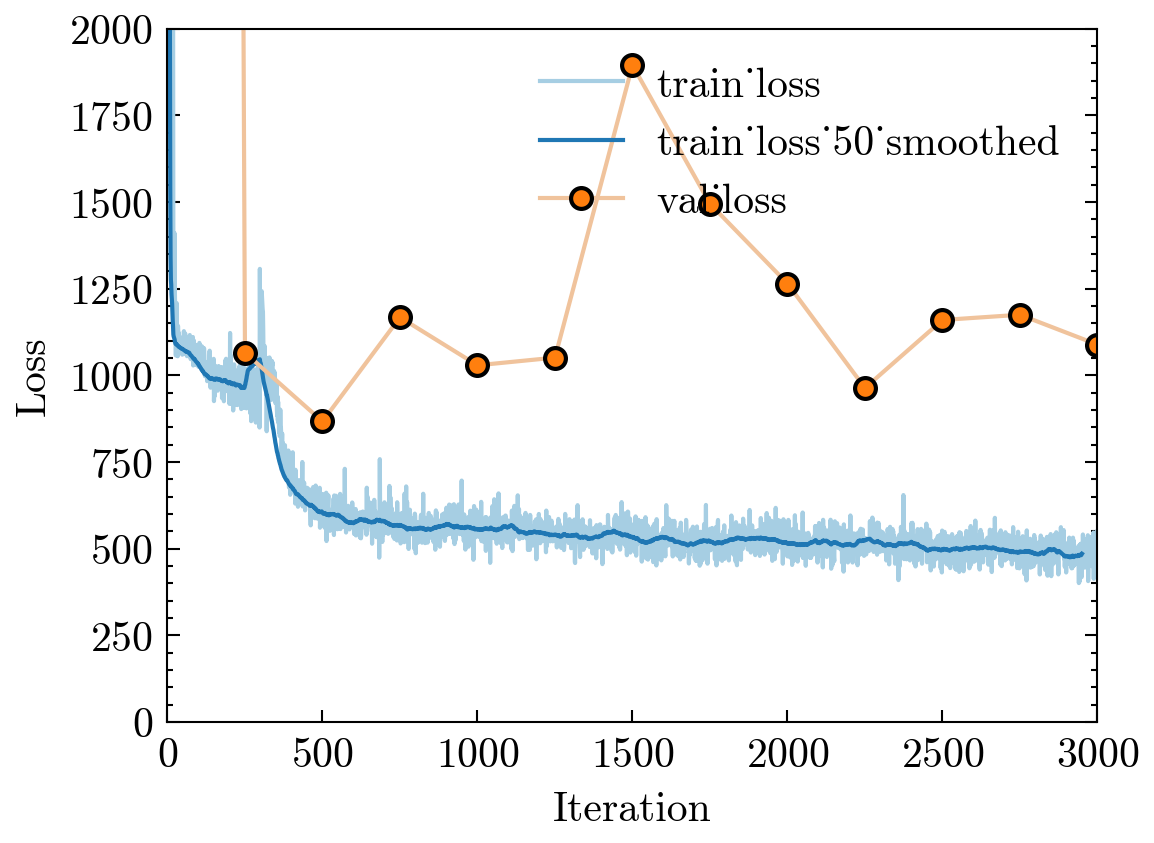

Test Loss: 1697.678424835205, use_knowledge=True, num_context=1
Test Loss: 1869.7543859481812, use_knowledge=False, num_context=1
Test Loss: 1039.4489531517029, use_knowledge=True, num_context=2
Test Loss: 1147.9987783432007, use_knowledge=False, num_context=2
Test Loss: 953.6560759544373, use_knowledge=True, num_context=3
Test Loss: 869.6802968978882, use_knowledge=False, num_context=3
Test Loss: 838.0969166755676, use_knowledge=True, num_context=4
Test Loss: 855.1447958946228, use_knowledge=False, num_context=4
Test Loss: 781.2136578559875, use_knowledge=True, num_context=5
Test Loss: 767.267728805542, use_knowledge=False, num_context=5
Test Loss: 785.1819357872009, use_knowledge=True, num_context=6
Test Loss: 764.8907527923584, use_knowledge=False, num_context=6
Test Loss: 744.2730531692505, use_knowledge=True, num_context=7
Test Loss: 759.3435864448547, use_knowledge=False, num_context=7
Test Loss: 729.9724688529968, use_knowledge=True, num_context=8
Test Loss: 736.1508593559265, u

[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [15:40:28])
[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [15:40:28])
[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [15:40:28])
[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [15:40:28])
[DEBUG]: XYEncoder has x_dim=1 and y_dim=1        (xy_encoders.py:57 [15:40:28])
[DEBUG]: XYEncoder has x_dim=1 and y_dim=1        (xy_encoders.py:57 [15:40:28])


Test Loss: 708.0811400413513, use_knowledge=False, num_context=10


[INFO]: Saving new best val loss model at iter 1        (train.py:122 [15:40:29])
[INFO]: Saving new best val loss model at iter 1        (train.py:122 [15:40:29])


iter 1: Val. Loss (NLL): 37947.2912902832


[INFO]: Removing model at path '../exp/surf_temp/np-rs-3_iter1.pt'        (train.py:129 [15:40:35])
[INFO]: Removing model at path '../exp/surf_temp/np-rs-3_iter1.pt'        (train.py:129 [15:40:35])
[INFO]: Saving new best val loss model at iter 250 to path ../exp/surf_temp/np-rs-3_iter250.pt        (train.py:134 [15:40:35])
[INFO]: Saving new best val loss model at iter 250 to path ../exp/surf_temp/np-rs-3_iter250.pt        (train.py:134 [15:40:35])


iter 250: Val. Loss (NLL): 1061.4974656105042
iter 500: Val. Loss (NLL): 1104.5967774391174
iter 750: Val. Loss (NLL): 1630.950628042221
iter 1000: Val. Loss (NLL): 1127.207989692688


[INFO]: Removing model at path '../exp/surf_temp/np-rs-3_iter250.pt'        (train.py:129 [15:41:08])
[INFO]: Removing model at path '../exp/surf_temp/np-rs-3_iter250.pt'        (train.py:129 [15:41:08])
[INFO]: Saving new best val loss model at iter 1250 to path ../exp/surf_temp/np-rs-3_iter1250.pt        (train.py:134 [15:41:08])
[INFO]: Saving new best val loss model at iter 1250 to path ../exp/surf_temp/np-rs-3_iter1250.pt        (train.py:134 [15:41:08])


iter 1250: Val. Loss (NLL): 796.6608555316925
iter 1500: Val. Loss (NLL): 1176.8730158805847
iter 1750: Val. Loss (NLL): 1243.006796836853
iter 2000: Val. Loss (NLL): 987.5811047554016
iter 2250: Val. Loss (NLL): 1879.5729229450226
iter 2500: Val. Loss (NLL): 871.1617958545685
iter 2750: Val. Loss (NLL): 1366.2362866401672
iter 3000: Val. Loss (NLL): 985.8085339069366
iter 3250: Val. Loss (NLL): 1333.642150402069
iter 3500: Val. Loss (NLL): 1584.0586228370667


[INFO]: time_since_prev_best_val >=5. EXITING TRAINING        (train.py:148 [15:42:17])
[INFO]: time_since_prev_best_val >=5. EXITING TRAINING        (train.py:148 [15:42:17])


iter 3750: Val. Loss (NLL): 1750.6925642490387


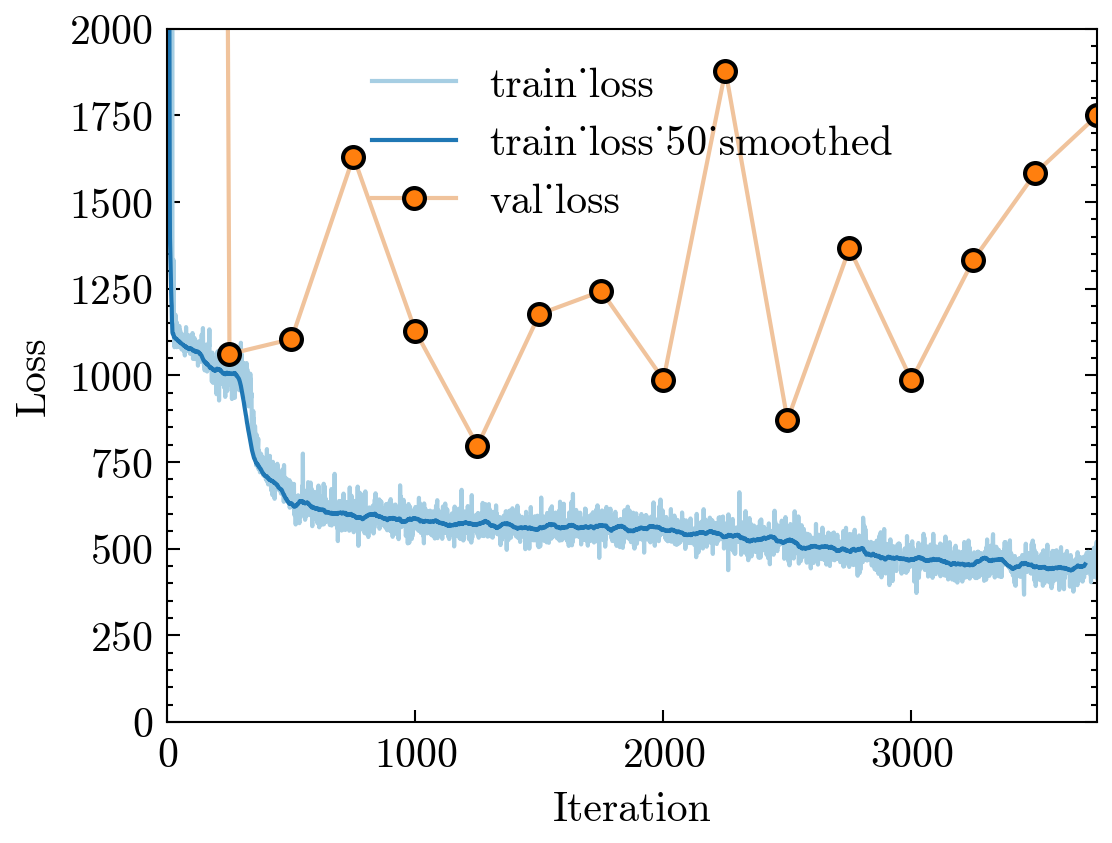

Test Loss: 3202.5975880622864, use_knowledge=True, num_context=1
Test Loss: 3567.750500202179, use_knowledge=False, num_context=1
Test Loss: 1489.5925741195679, use_knowledge=True, num_context=2
Test Loss: 1373.0188002586365, use_knowledge=False, num_context=2
Test Loss: 1091.082046031952, use_knowledge=True, num_context=3
Test Loss: 1020.027331829071, use_knowledge=False, num_context=3
Test Loss: 868.262891292572, use_knowledge=True, num_context=4
Test Loss: 889.3273906707764, use_knowledge=False, num_context=4
Test Loss: 852.9188227653503, use_knowledge=True, num_context=5
Test Loss: 831.1909670829773, use_knowledge=False, num_context=5
Test Loss: 771.817234992981, use_knowledge=True, num_context=6
Test Loss: 785.5959763526917, use_knowledge=False, num_context=6
Test Loss: 774.0142273902893, use_knowledge=True, num_context=7
Test Loss: 779.2038564682007, use_knowledge=False, num_context=7
Test Loss: 748.6455073356628, use_knowledge=True, num_context=8
Test Loss: 727.9175696372986, us

[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [15:42:45])
[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [15:42:45])
[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [15:42:45])
[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [15:42:45])
[DEBUG]: XYEncoder has x_dim=1 and y_dim=1        (xy_encoders.py:57 [15:42:45])
[DEBUG]: XYEncoder has x_dim=1 and y_dim=1        (xy_encoders.py:57 [15:42:45])
[INFO]: Saving new best val loss model at iter 1        (train.py:122 [15:42:46])
[INFO]: Saving new best val loss model at iter 1        (train.py:122 [15:42:46])


iter 1: Val. Loss (NLL): 51599.82684326172


[INFO]: Removing model at path '../exp/surf_temp/np-rs-44_iter1.pt'        (train.py:129 [15:42:52])
[INFO]: Removing model at path '../exp/surf_temp/np-rs-44_iter1.pt'        (train.py:129 [15:42:52])
[INFO]: Saving new best val loss model at iter 250 to path ../exp/surf_temp/np-rs-44_iter250.pt        (train.py:134 [15:42:52])
[INFO]: Saving new best val loss model at iter 250 to path ../exp/surf_temp/np-rs-44_iter250.pt        (train.py:134 [15:42:52])


iter 250: Val. Loss (NLL): 1096.93119430542


[INFO]: Removing model at path '../exp/surf_temp/np-rs-44_iter250.pt'        (train.py:129 [15:42:57])
[INFO]: Removing model at path '../exp/surf_temp/np-rs-44_iter250.pt'        (train.py:129 [15:42:57])
[INFO]: Saving new best val loss model at iter 500 to path ../exp/surf_temp/np-rs-44_iter500.pt        (train.py:134 [15:42:57])
[INFO]: Saving new best val loss model at iter 500 to path ../exp/surf_temp/np-rs-44_iter500.pt        (train.py:134 [15:42:57])


iter 500: Val. Loss (NLL): 928.224401473999
iter 750: Val. Loss (NLL): 1016.8109464645386
iter 1000: Val. Loss (NLL): 1957.1799087524414
iter 1250: Val. Loss (NLL): 1251.5478014945984
iter 1500: Val. Loss (NLL): 1745.4237146377563
iter 1750: Val. Loss (NLL): 1872.9918122291565
iter 2000: Val. Loss (NLL): 1955.9905605316162
iter 2250: Val. Loss (NLL): 2295.428687095642
iter 2500: Val. Loss (NLL): 1839.971570968628
iter 2750: Val. Loss (NLL): 1148.1664490699768


[INFO]: time_since_prev_best_val >=5. EXITING TRAINING        (train.py:148 [15:43:47])
[INFO]: time_since_prev_best_val >=5. EXITING TRAINING        (train.py:148 [15:43:47])


iter 3000: Val. Loss (NLL): 1803.4377083778381


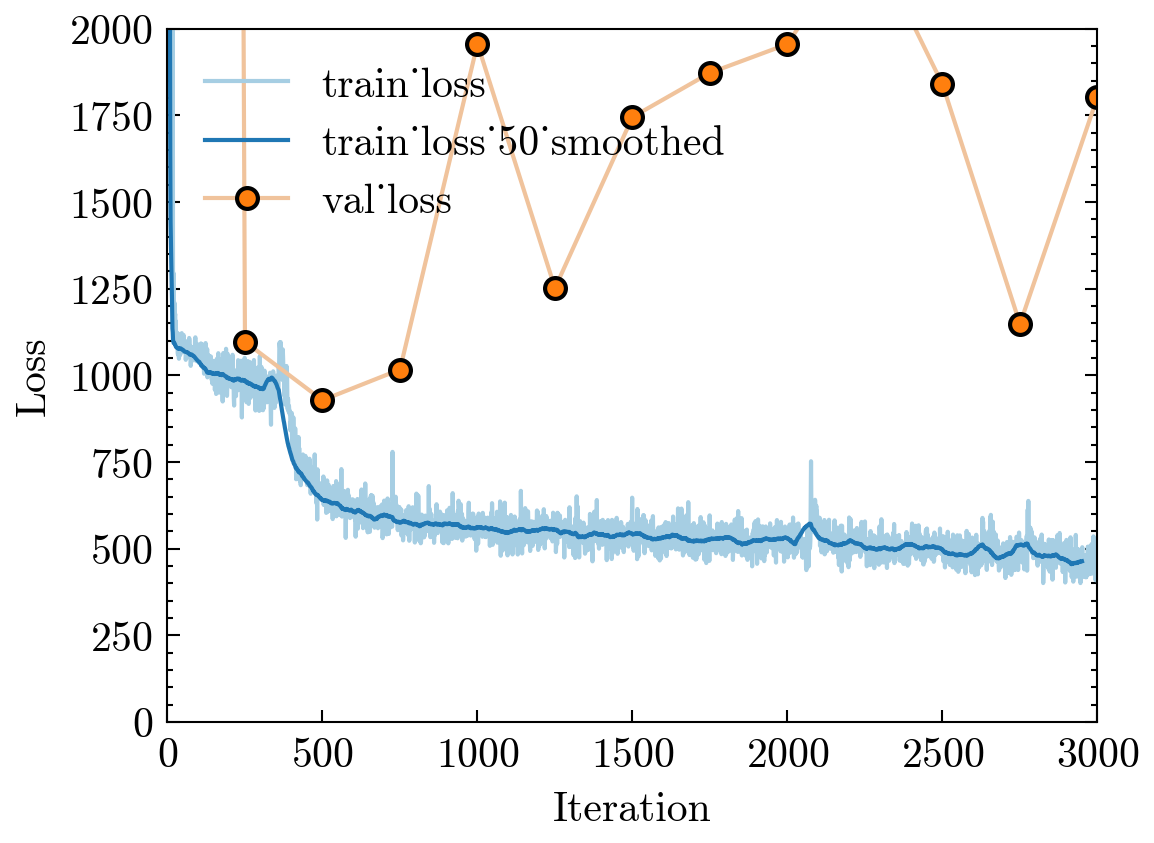

Test Loss: 2064.482729434967, use_knowledge=True, num_context=1
Test Loss: 1982.4508366584778, use_knowledge=False, num_context=1
Test Loss: 1111.6863074302673, use_knowledge=True, num_context=2
Test Loss: 1009.5426549911499, use_knowledge=False, num_context=2
Test Loss: 862.2428603172302, use_knowledge=True, num_context=3
Test Loss: 853.1277198791504, use_knowledge=False, num_context=3
Test Loss: 753.8549919128418, use_knowledge=True, num_context=4
Test Loss: 821.7677102088928, use_knowledge=False, num_context=4
Test Loss: 754.0663204193115, use_knowledge=True, num_context=5
Test Loss: 708.5010690689087, use_knowledge=False, num_context=5
Test Loss: 686.2035231590271, use_knowledge=True, num_context=6
Test Loss: 686.221001625061, use_knowledge=False, num_context=6
Test Loss: 692.5931849479675, use_knowledge=True, num_context=7
Test Loss: 681.7699208259583, use_knowledge=False, num_context=7
Test Loss: 665.7841730117798, use_knowledge=True, num_context=8
Test Loss: 648.9845724105835, u

In [20]:
#### NP ####
USE_KNOWLEDGE = False
logging.info(f'USE_KNOWLEDGE: {USE_KNOWLEDGE}')

np_k_test_losses_surf = np.zeros((len(random_states), MAX_NUM_CONTEXT))
np_nok_test_losses_surf = np.zeros((len(random_states), MAX_NUM_CONTEXT))
for idx, random_state in enumerate(random_states):
    data = TempData(data=data_df , max_num_context=MAX_NUM_CONTEXT, device=DEVICE, random_state=random_state)

    np_model = InformedNeuralProcess(
        **args,
        use_knowledge=USE_KNOWLEDGE
    ).to(DEVICE)
    np_optimiser = torch.optim.Adam(np_model.parameters(), lr=LEARNING_RATE)
    
    np_model, best_np_model_path, optimiser, train_losses, val_losses = train(model=np_model,
                                                       data=data,
                                                       loss_function=loss_function,
                                                       optimiser=np_optimiser,
                                                       device=DEVICE,
                                                       use_knowledge=USE_KNOWLEDGE,
                                                       max_iters=MAX_ITERS,
                                                       avg_loss_print_interval=AVG_LOSS_PRINT_INTERVAL,
                                                       plot_sample_interval=PLOT_SAMPLE_INTERVAL,
                                                       model_save_name=f"surf_temp/np-rs-{random_state}",
                                                                               verbose=False)
    np_model.load_state_dict(torch.load(best_np_model_path))
    k_test_losses, nok_test_losses = k_and_nok_eval(np_model, data)
    np_k_test_losses_surf[idx] = k_test_losses
    np_nok_test_losses_surf[idx] = nok_test_losses

print()
print(np_k_test_losses_surf.mean(axis=0), np_k_test_losses_surf.std(axis=0))
print(np_nok_test_losses_surf.mean(axis=0), np_nok_test_losses_surf.std(axis=0))

In [23]:
#### INP ####
USE_KNOWLEDGE = True
logging.info(f'USE_KNOWLEDGE: {USE_KNOWLEDGE}')
KNOWLEDGE_DROPOUT_RATE = 0.45
logging.info(f"Knowledge Dropout {KNOWLEDGE_DROPOUT_RATE}")

inp_k_test_losses_surf_045 = np.zeros((len(random_states), MAX_NUM_CONTEXT))
inp_nok_test_losses_surf_045 = np.zeros((len(random_states), MAX_NUM_CONTEXT))

model_paths = ["../exp/surf_temp/inp-surftemp-kdrop045-rs-66_iter4250.pt", "../exp/surf_temp/inp-surftemp-kdrop045-rs-3_iter2000.pt", "../exp/surf_temp/inp-surftemp-kdrop045-rs-44_iter1500.pt"]

for ridx, random_state in enumerate(random_states):
    data = TempData(data=data_df, max_num_context=MAX_NUM_CONTEXT, device=DEVICE, random_state=random_state)
    
    inp_model = InformedNeuralProcess(
        **args,
        knowledge_dropout=KNOWLEDGE_DROPOUT_RATE,
        use_knowledge=USE_KNOWLEDGE
    ).to(DEVICE)
    # inp_optimiser = torch.optim.Adam(inp_model.parameters(), lr=LEARNING_RATE)
    
    # inp_model, best_inp_model_path, optimiser, train_losses, val_losses = train(model=inp_model,
    #                                                    data=data,
    #                                                    loss_function=loss_function,
    #                                                    optimiser=inp_optimiser,
    #                                                    device=DEVICE,
    #                                                    use_knowledge=USE_KNOWLEDGE,
    #                                                    max_iters=MAX_ITERS,
    #                                                    avg_loss_print_interval=AVG_LOSS_PRINT_INTERVAL,
    #                                                    plot_sample_interval=PLOT_SAMPLE_INTERVAL,
    #                                                    model_save_name=f"surf_temp/inp-surftemp-kdrop045-rs-{random_state}",
    #                                                                            verbose=False)
    inp_model.load_state_dict(torch.load(model_paths[ridx]))
    k_test_losses, nok_test_losses = k_and_nok_eval(inp_model, data)
    inp_k_test_losses_surf_045[ridx] = k_test_losses
    inp_nok_test_losses_surf_045[ridx] = nok_test_losses
    
    print()
print(inp_k_test_losses_surf_045.mean(axis=0), inp_k_test_losses_surf_045.std(axis=0))
print(inp_nok_test_losses_surf_045.mean(axis=0), inp_nok_test_losses_surf_045.std(axis=0))


[INFO]: USE_KNOWLEDGE: True        (116400746.py:3 [16:04:44])
[INFO]: USE_KNOWLEDGE: True        (116400746.py:3 [16:04:44])
[INFO]: Knowledge Dropout 0.45        (116400746.py:5 [16:04:44])
[INFO]: Knowledge Dropout 0.45        (116400746.py:5 [16:04:44])
[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [16:04:45])
[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [16:04:45])
[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [16:04:45])
[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [16:04:45])
[DEBUG]: XYEncoder has x_dim=1 and y_dim=1        (xy_encoders.py:57 [16:04:45])
[DEBUG]: XYEncoder has x_dim=1 and y_dim=1        (xy_encoders.py:57 [16:04:45])
[DEBUG]: Resetting dropped connection: huggingface.co        (connectionpool.py:291 [16:04:45])
[DEBUG]: Resetting dropped connection: huggingface.co        (connectionpool.py:291 [16:04:45])
[DEBUG]: https://huggingface.co:443 "HEAD /roberta-b

Test Loss: 891.2069234848022, use_knowledge=True, num_context=1
Test Loss: 1433.6236128807068, use_knowledge=False, num_context=1
Test Loss: 738.3120641708374, use_knowledge=True, num_context=2
Test Loss: 807.4610209465027, use_knowledge=False, num_context=2
Test Loss: 669.8945155143738, use_knowledge=True, num_context=3
Test Loss: 698.0233640670776, use_knowledge=False, num_context=3
Test Loss: 636.9544486999512, use_knowledge=True, num_context=4
Test Loss: 633.9503498077393, use_knowledge=False, num_context=4
Test Loss: 610.5971593856812, use_knowledge=True, num_context=5
Test Loss: 612.8955783843994, use_knowledge=False, num_context=5
Test Loss: 595.9993176460266, use_knowledge=True, num_context=6
Test Loss: 593.1505928039551, use_knowledge=False, num_context=6
Test Loss: 597.4012989997864, use_knowledge=True, num_context=7
Test Loss: 595.4655485153198, use_knowledge=False, num_context=7
Test Loss: 585.4210433959961, use_knowledge=True, num_context=8
Test Loss: 578.2605862617493, us

[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [16:07:03])
[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [16:07:03])
[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [16:07:03])
[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [16:07:03])
[DEBUG]: XYEncoder has x_dim=1 and y_dim=1        (xy_encoders.py:57 [16:07:03])
[DEBUG]: XYEncoder has x_dim=1 and y_dim=1        (xy_encoders.py:57 [16:07:03])


Test Loss: 558.3923606872559, use_knowledge=False, num_context=10



[DEBUG]: https://huggingface.co:443 "HEAD /roberta-base/resolve/main/config.json HTTP/1.1" 200 0        (connectionpool.py:474 [16:07:04])
[DEBUG]: https://huggingface.co:443 "HEAD /roberta-base/resolve/main/config.json HTTP/1.1" 200 0        (connectionpool.py:474 [16:07:04])
[DEBUG]: https://huggingface.co:443 "HEAD /roberta-base/resolve/main/config.json HTTP/1.1" 200 0        (connectionpool.py:474 [16:07:04])
[DEBUG]: https://huggingface.co:443 "HEAD /roberta-base/resolve/main/config.json HTTP/1.1" 200 0        (connectionpool.py:474 [16:07:04])
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[DEBUG]: Freezing LLM parameters        (knowledge_encoder.py:30 [16:07:04])
[DEBUG]: Freezing LLM parameters        (knowledge_encoder.py:30 [16:07:04])

Test Loss: 3043.1997809410095, use_knowledge=True, num_context=1
Test Loss: 6189.642366409302, use_knowledge=False, num_context=1
Test Loss: 1424.535313129425, use_knowledge=True, num_context=2
Test Loss: 1989.8296284675598, use_knowledge=False, num_context=2
Test Loss: 976.3363032341003, use_knowledge=True, num_context=3
Test Loss: 1368.6536197662354, use_knowledge=False, num_context=3
Test Loss: 791.7331657409668, use_knowledge=True, num_context=4
Test Loss: 1109.5751237869263, use_knowledge=False, num_context=4
Test Loss: 760.3479843139648, use_knowledge=True, num_context=5
Test Loss: 1015.8341407775879, use_knowledge=False, num_context=5
Test Loss: 757.3145666122437, use_knowledge=True, num_context=6
Test Loss: 891.7339925765991, use_knowledge=False, num_context=6
Test Loss: 750.0676708221436, use_knowledge=True, num_context=7
Test Loss: 834.0916676521301, use_knowledge=False, num_context=7
Test Loss: 695.3024134635925, use_knowledge=True, num_context=8
Test Loss: 843.9713997840881

[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [16:09:24])
[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [16:09:24])
[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [16:09:24])
[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [16:09:24])
[DEBUG]: XYEncoder has x_dim=1 and y_dim=1        (xy_encoders.py:57 [16:09:24])
[DEBUG]: XYEncoder has x_dim=1 and y_dim=1        (xy_encoders.py:57 [16:09:24])


Test Loss: 792.4492273330688, use_knowledge=False, num_context=10



[DEBUG]: https://huggingface.co:443 "HEAD /roberta-base/resolve/main/config.json HTTP/1.1" 200 0        (connectionpool.py:474 [16:09:25])
[DEBUG]: https://huggingface.co:443 "HEAD /roberta-base/resolve/main/config.json HTTP/1.1" 200 0        (connectionpool.py:474 [16:09:25])
[DEBUG]: https://huggingface.co:443 "HEAD /roberta-base/resolve/main/config.json HTTP/1.1" 200 0        (connectionpool.py:474 [16:09:25])
[DEBUG]: https://huggingface.co:443 "HEAD /roberta-base/resolve/main/config.json HTTP/1.1" 200 0        (connectionpool.py:474 [16:09:25])
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[DEBUG]: Freezing LLM parameters        (knowledge_encoder.py:30 [16:09:25])
[DEBUG]: Freezing LLM parameters        (knowledge_encoder.py:30 [16:09:25])

Test Loss: 1227.33971118927, use_knowledge=True, num_context=1
Test Loss: 1480.3969645500183, use_knowledge=False, num_context=1
Test Loss: 902.8423418998718, use_knowledge=True, num_context=2
Test Loss: 977.9584422111511, use_knowledge=False, num_context=2
Test Loss: 814.857880115509, use_knowledge=True, num_context=3
Test Loss: 835.2440896034241, use_knowledge=False, num_context=3
Test Loss: 707.8680715560913, use_knowledge=True, num_context=4
Test Loss: 727.4137578010559, use_knowledge=False, num_context=4
Test Loss: 659.6534814834595, use_knowledge=True, num_context=5
Test Loss: 676.7775225639343, use_knowledge=False, num_context=5
Test Loss: 630.6435513496399, use_knowledge=True, num_context=6
Test Loss: 662.8135213851929, use_knowledge=False, num_context=6
Test Loss: 619.4797296524048, use_knowledge=True, num_context=7
Test Loss: 638.389844417572, use_knowledge=False, num_context=7
Test Loss: 622.9292345046997, use_knowledge=True, num_context=8
Test Loss: 629.3723487854004, use_k

In [31]:
# np.save("inp_k_test_losses-05-surf.npy", inp_k_test_losses_surf) 
# np.save("inp_nok_test_losses-05-surf.npy", inp_nok_test_losses_surf) 

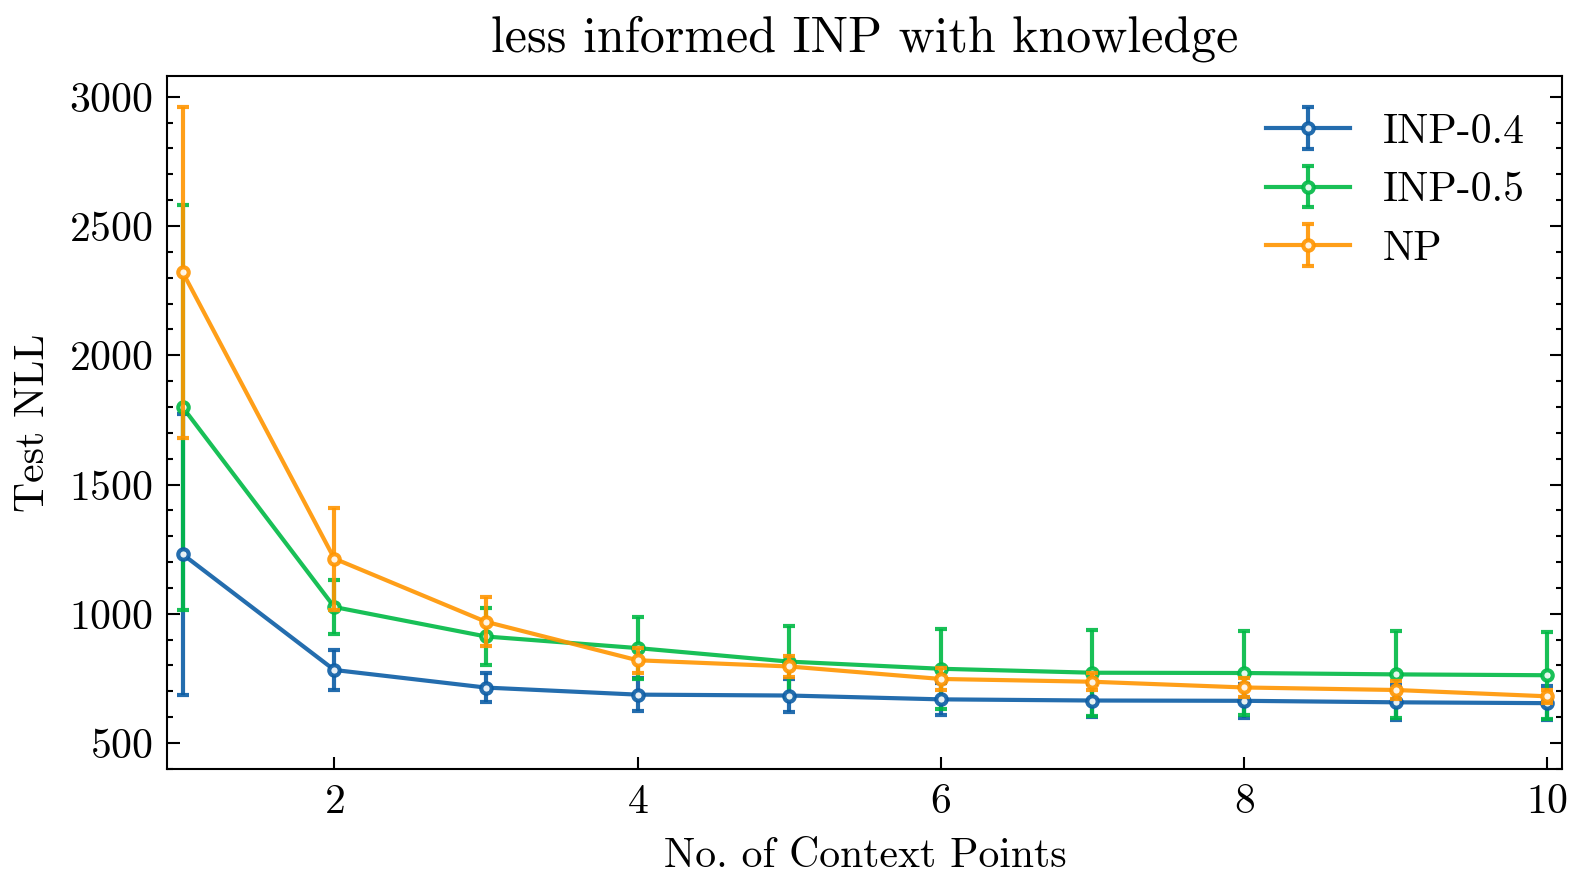

In [21]:
inp_k_test_losses_surf_04 = np.load("inp_k_test_losses-04-surf.npy")
inp_nok_test_losses_surf_04 = np.load("inp_nok_test_losses-04-surf.npy")

plt.style.use('../figures/mplstyles/thesis.mplstyle')

# Plot the data
plt.figure(figsize=(6, 3))
num_context_points = range(1, 11)
# plt.plot(num_context_points, inp_test_losses_array.mean(axis=0), label='INP', marker='o', markersize=3)
# plt.plot(num_context_points, np_test_losses_array.mean(axis=0), label='NP', marker='x', markersize=3)
# print(inp_k_test_losses_surf.shape)
    
plt.errorbar(num_context_points, 
                 inp_k_test_losses_surf_04.squeeze().mean(axis=0), 
                 yerr=inp_k_test_losses_surf_04.squeeze().std(axis=0), 
                 capsize=1.5,marker='o', linestyle='-', markersize=2.5, 
                 alpha=0.9, mfc='white',zorder=11, label=f"INP-0.4")
plt.errorbar(num_context_points, 
                 inp_k_test_losses_surf.squeeze().mean(axis=0), 
                 yerr=inp_k_test_losses_surf.squeeze().std(axis=0), 
                 capsize=1.5,marker='o', linestyle='-', markersize=2.5, 
                 alpha=0.9, mfc='white',zorder=11, label=f"INP-0.5")

plt.errorbar(num_context_points, 
             np_k_test_losses_surf.squeeze().mean(axis=0), 
             yerr=np_k_test_losses_surf.squeeze().std(axis=0), 
             capsize=1.5,  marker='o', markersize=2.5,  linestyle='-',
              alpha=0.9, mfc='white',zorder=12, label="NP")

plt.xlabel('No. of Context Points')
plt.ylabel('Test NLL')
plt.title("less informed INP with knowledge")
plt.legend()
plt.xlim(0.9, 10.1)
plt.ylim(400,)
# plt.grid()
# plt.savefig(f'../figures/knowledge-inp_vs_np_surf_temp.png', dpi=600)
plt.show()

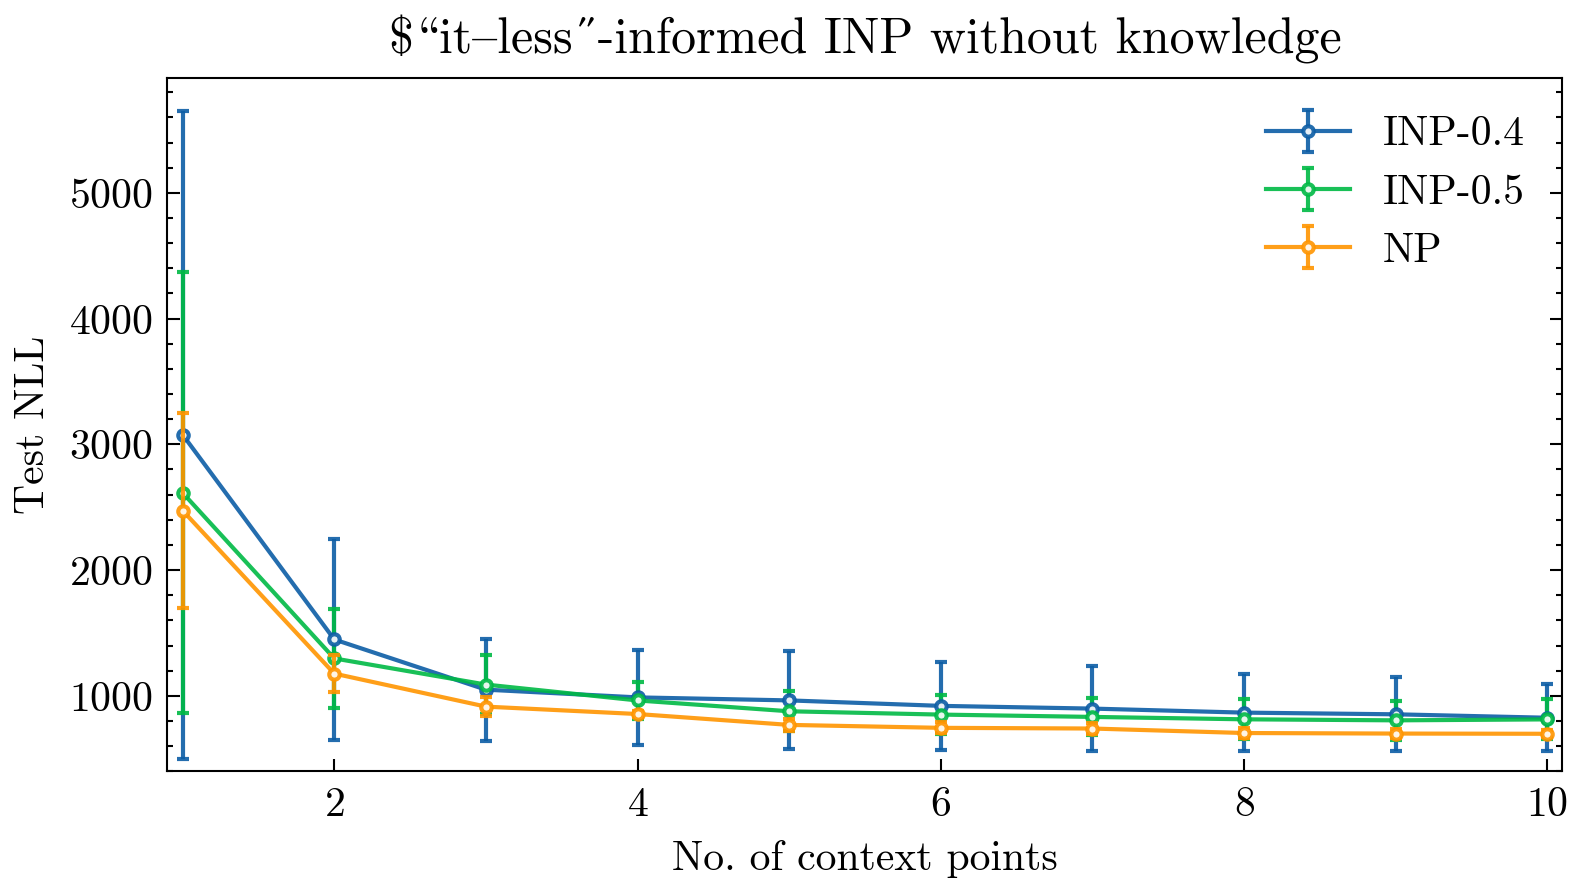

In [22]:
# Plot the data
plt.figure(figsize=(6, 3))
num_context_points = range(1, 11)
# plt.plot(num_context_points, inp_test_losses_array.mean(axis=0), label='INP', marker='o', markersize=3)
# plt.plot(num_context_points, np_test_losses_array.mean(axis=0), label='NP', marker='x', markersize=3)
# print(inp_k_test_losses_surf.shape)
    
plt.errorbar(num_context_points, 
                 inp_nok_test_losses_surf_04.squeeze().mean(axis=0), 
                 yerr=inp_nok_test_losses_surf_04.squeeze().std(axis=0), 
                 capsize=1.5,marker='o', linestyle='-', markersize=2.5, 
                 alpha=0.9, mfc='white',zorder=11, label=f"INP-0.4")

plt.errorbar(num_context_points, 
                 inp_nok_test_losses_surf.squeeze().mean(axis=0), 
                 yerr=inp_nok_test_losses_surf.squeeze().std(axis=0), 
                 capsize=1.5,marker='o', linestyle='-', markersize=2.5,
                 alpha=0.9, mfc='white',zorder=11, label=f"INP-0.5")


plt.errorbar(num_context_points, 
             np_nok_test_losses_surf.squeeze().mean(axis=0), 
             yerr=np_nok_test_losses_surf.squeeze().std(axis=0), 
             capsize=1.5,  marker='o', markersize=2.5,  linestyle='-',
              alpha=0.9, mfc='white',zorder=12, label="NP")

plt.xlabel('No. of context points')
plt.ylabel('Test NLL')
plt.title("$\it{less}-informed INP without knowledge")
plt.legend()
plt.xlim(0.9, 10.1)
plt.ylim(400,)
# plt.grid()
# plt.savefig(f'../figures/noknowledge-inp_vs_np_surf_temp.png', dpi=600)
plt.show()
